In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Modelling & Predictions

In [1]:
# Data reading and processing
import re
import pandas as pd
import numpy as np
import warnings
from scipy.stats import randint as sp_randint
from datetime import datetime

import os
from os import path

# Visualisation
from matplotlib import pyplot as plt
from pandas_ml import ConfusionMatrix

# Modelling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting current directory as same directory where code is stored
try:
    CUR_DIR = dirname(realpath(__file__))
except NameError:
    CUR_DIR = os.getcwd()

In [3]:
# Additional functions
## Print confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

        
## Calculating distance        
def pythagoras(long1, long2, lat1, lat2):
    import math
    a = abs(long1-long2)**2
    b = abs(lat1-lat2)**2
    return math.sqrt(a+b)

## Reading in data

In [4]:
# Import data files
train = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'trainingData.csv'),index_col=None)
test = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'validationData.csv'),index_col=None)

print('Training dataset (length, width) = %s' % str(train.shape))
print('Validation dataset (length, width) = %s' % str(test.shape))

# Import mapping files
map_user = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'userMap.csv'),index_col=None)
map_phone = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'phoneMap.csv'),index_col=None)

Training dataset (length, width) = (19937, 529)
Validation dataset (length, width) = (1111, 529)


## Removing columns
As per EDA, certain WAPs do not have RSSI values across all records. These columns are removed. 

In [5]:
sub_train = train[[x for x in train.columns if 'WAP' not in x]]
sub_train['max_signal'] = train.loc[:,[x for x in train.columns if 'WAP' in x]].replace(100,np.NaN).max(axis=1)
nan_sub = sub_train.loc[np.isnan(sub_train['max_signal']),]
nan_rows = sub_train['max_signal'].isnull().sum()
nan_rows_index = nan_sub.index.tolist()
train = train.iloc[[x for x in train.index if x not in nan_rows_index]]
wap_max = train[[x for x in train.columns if 'WAP' in x]].replace(100,np.nan).max(axis=0).reset_index()
wap_max = wap_max.rename(columns={'index':'wap_name', 0: 'max_signal'}).fillna(10)
cols_torm = wap_max.loc[wap_max['max_signal']==10,'wap_name'].tolist()
train = train.drop(train[cols_torm],axis=1)
test = test.drop(test[cols_torm],axis=1)

print('Number of WAP variables removed: %i' % len(cols_torm))
print('Remaining WAP variables: %i' % len([x for x in train.columns if 'WAP' in x]))

Number of WAP variables removed: 55
Remaining WAP variables: 465


# Predictive Modelling

## a) Classification Algorithms

### Input variables: WAP001 to WAP520
Excluding the 55 WAP variables with no RSSI readings
### Target variables: Building and Floor
Total classes: 13 (cross join of all available buildings and floors)

In [6]:
# Creates single variable combining both targets
train['target'] = 'B' + train['BUILDINGID'].astype(str) + ' x F' + train['FLOOR'].astype(str)
test['target'] = 'B' + test['BUILDINGID'].astype(str) + ' x F' + test['FLOOR'].astype(str)

### Step 1: Algorithm selection

* A mixture of 6 linear and non-linear models are selected
* Using 10-fold cross validation to evaluate which model has the highest **accuracy**

In [7]:
class_models = []
class_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
class_models.append(('Logistic Regression', LogisticRegression()))
class_models.append(('K-Nearest Neighbours', KNeighborsClassifier()))
class_models.append(('Decision Tree', DecisionTreeClassifier()))
class_models.append(('Random Forest', RandomForestClassifier()))
class_models.append(('Neural Network', MLPClassifier()))

# evaluate each model in turn
class_results = []
class_names = []
for name, model in class_models:
    kfold = KFold(n_splits=10, random_state=20)
    cv_results = cross_val_score(model, train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel(), cv=kfold, scoring='accuracy',n_jobs=-1)
    class_results.append(cv_results)
    class_names.append(name)
    msg = "%s: %.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Linear Discriminant Analysis: 0.7973 (0.1292)


KeyboardInterrupt: 

In [0]:
# Compare Algorithms
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(class_results)
ax.set_xticklabels(class_names,rotation=40)
plt.show()

NameError: name 'plt' is not defined

**Random Forest** produces the highest average accuracy, hence will be the model selected for the classification.

### Step 2: Running model and evaluation of results
Algorithm selected: **Random Forest**

In [0]:
class_rf = RandomForestClassifier(random_state=20, n_jobs=-1)
class_rf.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
class_preds = class_rf.predict(test[[x for x in train.columns if 'WAP' in x]])
print("Accuracy: %.2f%%\n" % (accuracy_score(test['target'].ravel(), class_preds)*100))

Accuracy: 82.00%



In [0]:
class_cm = confusion_matrix(test['target'].ravel(), class_preds)

print("Confusion Matrix:\n")
print_cm(class_cm, sorted(list(set(class_preds))))

Confusion Matrix:

            B0 x F0 B0 x F1 B0 x F2 B0 x F3 B1 x F0 B1 x F1 B1 x F2 B1 x F3 B2 x F0 B2 x F1 B2 x F2 B2 x F3 B2 x F4 
    B0 x F0      71       1       6       0       0       0       0       0       0       0       0       0       0 
    B0 x F1      27     171       8       0       0       0       0       2       0       0       0       0       0 
    B0 x F2       1       8     150       6       0       0       0       0       0       0       0       0       0 
    B0 x F3       0       0       8      77       0       0       0       0       0       0       0       0       0 
    B1 x F0       0       0       0       0      22       2       4       2       0       0       0       0       0 
    B1 x F1       0       0       1       0      10      91      37       4       0       0       0       0       0 
    B1 x F2       0       0       0       0       0       0      80       7       0       0       0       0       0 
    B1 x F3       0       0       0       0  

* X-axis: Predicted
* Y-axis: Actual

To make the results easier to interpret, graphical representation of the **normalised** confusion matrix is shown below.

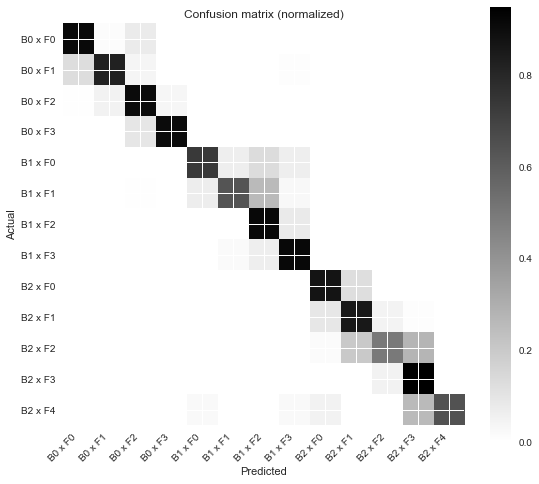

In [0]:
ConfusionMatrix(test['target'].ravel(), class_preds).plot(normalized=True)
plt.show()

* Most records can be accurately classified to the correct building
* The building with lowest overall accuracy is **Building 2** - this is to be expected as Building 2 is the largest building (having 4 floors and based on number of records)
* The least accurately classified area is **B2 x L2**
* B2 x L4 has the highest variation in number of predicted classes

In [0]:
class_results = pd.concat([test[['BUILDINGID','FLOOR']], pd.DataFrame(data=class_preds,columns=['pred'])],axis=1)
class_results['pred'] = class_results['pred'].str.split(' x ')
class_results['pred_building'] = class_results['pred'].apply(lambda x: int(re.sub(r'[^0-9^\-\.]+', '', x[0])))
class_results['pred_floor'] = class_results['pred'].apply(lambda x: int(re.sub(r'[^0-9^\-\.]+', '', x[1])))

correct_mat = np.zeros((3,5))
pred_mat = np.zeros((3,5))
for i, row in class_results.iterrows():
    correct_mat[row['BUILDINGID'],row['FLOOR']] += 1
    pred_mat[row['pred_building'],row['pred_floor']] += 1

sc_corr=np.corrcoef([item for sublist in signal_fb.values.tolist() for item in sublist], [item for sublist in np.nan_to_num(abs(correct_mat-pred_mat)/correct_mat).tolist() for item in sublist])[0,1]
print('Correlation coefficient between Accuracy and Average Max Signal Strength: %.4f' % sc_corr)

Correlation coefficient between Accuracy and Average Max Signal Strength: -0.4815


There is a moderate negative relationship between Prediction Accuracy and Max Signal Strength - 48.15% of the predicted accuracy by building x floor can be explained by how strong the max signal is.

### Step 3: Model improvements
Given the current accuracy of 82%, the current Random Forest model can be further improved by hyperparameter tuning.

In [0]:
# Random search to get best hyperparameter grid
random_grid = {'bootstrap': [True, False],
               'criterion': ['gini', 'entropy'],
               'max_features': ['auto', 'sqrt', None],
               'min_samples_leaf': sp_randint(1, 11),
               'min_samples_split': sp_randint(2, 11),
               'n_estimators': sp_randint(1, 2000),
               'max_depth': sp_randint(1, 100)
              }
## Randomised search with 5-fold validation
class_rf_random = RandomizedSearchCV(estimator = class_rf, param_distributions = random_grid, n_iter = 50, verbose=2, random_state=20, n_jobs = -1)
## Fit the random search model
class_rf_random.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 146.2min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=20,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', None], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C72EF98>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C6D2C50>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C066C50>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000

In [0]:
## Compare aganst original model
base_accuracy = accuracy_score(test['target'].ravel(), class_preds)
random_accuracy = class_rf_random.best_score_
print('Base accuracy: %.2f%%' % (base_accuracy*100))
print('Best accuracy from Randomized Search: %.2f%%' % (random_accuracy*100))
print('Improvement of %.2f%%.' % (100 * (random_accuracy - base_accuracy) / base_accuracy))

Base accuracy: 82.00%
Best accuracy from Randomized Search: 92.00%
Improvement of 12.20%.


Using the hyperparameters that produces the highest accuracy, the model is tuned to produce the following results:

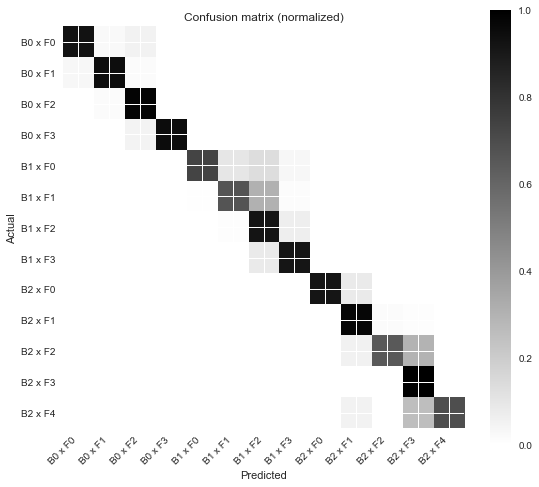

In [0]:
rf_tuned = RandomForestClassifier(random_state=20, n_jobs=-1, bootstrap=False, criterion='gini', max_depth=44, max_features='auto', min_samples_leaf=1,min_samples_split=3, n_estimators=1925)
rf_tuned.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
class_preds_tuned = rf_tuned.predict(test[[x for x in train.columns if 'WAP' in x]])

ConfusionMatrix(test['target'].ravel(), class_preds_tuned).plot(normalized=True)
plt.show()

### Classification Model Evaluation

In [0]:
class_results = pd.concat([test[['target']], 
                          pd.DataFrame(columns=['Predicted'],
                                      data=class_preds),
                          pd.DataFrame(columns=['Predicted_Tuned'],
                                      data=class_preds_tuned)],axis=1)

class_results = class_results.apply(lambda x: x.str.split(' x '))
class_results['pred_building'] = class_results.apply(lambda row: row['target'][0] == row['Predicted'][0], axis=1)
class_results['pred_floor'] = class_results.apply(lambda row: row['target'][1] == row['Predicted'][1], axis=1)
class_results['pred_tuned_building'] = class_results.apply(lambda row: row['target'][0] == row['Predicted_Tuned'][0], axis=1)
class_results['pred_tuned_floor'] = class_results.apply(lambda row: row['target'][1] == row['Predicted_Tuned'][1], axis=1)

org_bldg = class_results['pred_building'].sum()/len(class_results)
org_floor = class_results['pred_floor'].sum()/len(class_results)
tuned_bldg = class_results['pred_tuned_building'].sum()/len(class_results)
tuned_floor = class_results['pred_tuned_floor'].sum()/len(class_results)
print('With original predictions, the percentage of correctly classified BUILDINGS = %.2f%%' % (org_bldg*100))
print('With original predictions, the percentage of correctly classified FLOORS = %.2f%%' % (org_floor*100))
print()
print('With TUNED predictions, the percentage of correctly classified BUILDINGS = %.2f%% (%.2f%% improvement)' % ((tuned_bldg*100),((tuned_bldg-org_bldg)/org_bldg*100)))
print('With TUNED predictions, the percentage of correctly classified FLOORS = %.2f%% (%.2f%% improvement)' % ((tuned_floor*100),((tuned_floor-org_floor)/org_floor*100)))

With original predictions, the percentage of correctly classified BUILDINGS = 99.55%
With original predictions, the percentage of correctly classified FLOORS = 82.00%

With TUNED predictions, the percentage of correctly classified BUILDINGS = 100.00% (0.45% improvement)
With TUNED predictions, the percentage of correctly classified FLOORS = 88.66% (8.12% improvement)


## b) Regression Algorithms

### Input variables: WAP001 to WAP520
Excluding the 55 WAP variables with no RSSI readings
### Target variables: Latitude and Longitude

### Step 1: Algorithm selection

* A mixture of 6 linear and non-linear models are selected
* Using 10-fold cross validation to evaluate which model has the highest **accuracy**

In [0]:
reg_models = []
reg_models.append(('Lasso Regression', Lasso()))
reg_models.append(('Ridge Regression', Ridge()))
reg_models.append(('ElasticNet Regression', ElasticNet()))
reg_models.append(('K-Nearest Neighbours', KNeighborsRegressor()))
reg_models.append(('Random Forest', RandomForestRegressor()))
reg_models.append(('Gradient Boosting', GradientBoostingRegressor()))

# evaluate each model in turn
reg_results = []
reg_names = []
for name, model in reg_models:
    kfold = KFold(n_splits=10, random_state=20)
    model = MultiOutputRegressor(model)
    cv_results = cross_val_score(model, train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values, cv=kfold, scoring='neg_mean_squared_error',n_jobs=-1)
    reg_results.append(cv_results)
    reg_names.append(name)
    msg = "%s: %.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Lasso Regression: -855.4455 (354.0631)
Ridge Regression: -1766.2010 (2706.2820)
ElasticNet Regression: -858.4744 (355.0012)
K-Nearest Neighbours: -121.7157 (63.8480)
Random Forest: -162.3364 (110.4996)
Gradient Boosting: -510.0639 (146.8694)


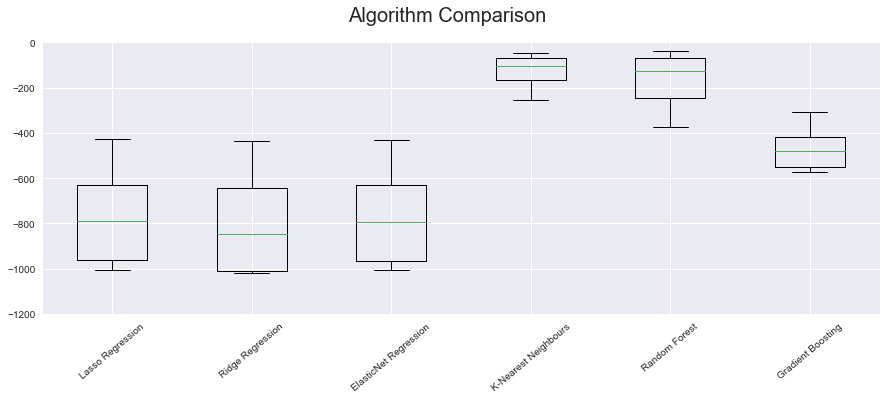

In [0]:
# Compare Algorithms
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(reg_results)
ax.set_xticklabels(reg_names,rotation=40)
ax.set_ylim(top=0, bottom=-1200)
plt.show()

**K-Nearest Neighbours** produces the lowest negative mean squared error, hence will be the model selected for the classification.

### Step 2: Running model and evaluation of results
Algorithm selected: **K-Nearest Neighbours**

In [0]:
reg_knn = MultiOutputRegressor(KNeighborsRegressor(), n_jobs=-1)
reg_knn.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
reg_preds = reg_knn.predict(test[[x for x in train.columns if 'WAP' in x]])

rsq = r2_score(test[['LATITUDE','LONGITUDE']].values, reg_preds)
print('R-squared score: %.4f' % rsq)
print('Mean Squared Error:')
ll_mse = dict(zip(['Latitude', 'Longitude'], mean_squared_error(test[['LATITUDE','LONGITUDE']].values, reg_preds, multioutput='raw_values')))
for k, v in ll_mse.items():
    print('\t%s: %.2f' % (k, v))

R-squared score: 0.9753
Mean Squared Error:
	Latitude: 206.76
	Longitude: 272.66


Although the R-squared score is very close to 1, a more intuitive measure of the results must be calculated to represent accuracy.

The distance between the predicted and actual long-lat can be calculated given these assumptions:
* Longitude and Latitude are actually Northing and Easting coordinates (respectively)
* Given that no UTM Zone is provided, the coordinates are assumed to be on a simple grid
* Distance between 2 points is calculated by applying the Pythagoras theorem
* Unit of distance = meters (m)

In [0]:
test_sub = pd.concat([test[['LATITUDE','LONGITUDE', 'BUILDINGID', 'FLOOR']], 
                     pd.DataFrame(columns=['pred_lat','pred_long'], data = reg_preds)],axis=1)
test_sub['dist_error'] = test_sub.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long'], row['LATITUDE'], row['pred_lat']),axis=1)

org_ar = test_sub['dist_error'].mean()
print('On average, the current model is accurate up to %.2fm radius.' % org_ar)

On average, the current model is accurate up to 13.15m radius.


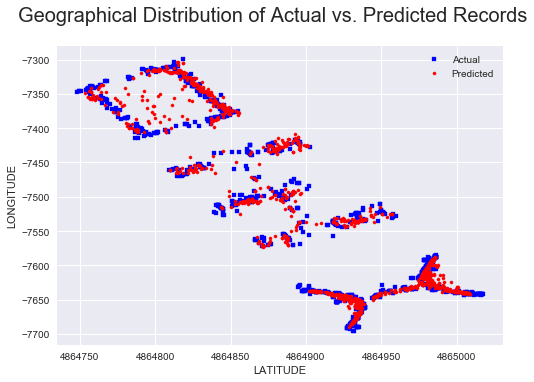

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.suptitle('Geographical Distribution of Actual vs. Predicted Records',fontsize=20)
ax1.scatter(test_sub['LATITUDE'], test_sub['LONGITUDE'], s=10, c='b', marker="s", label='Actual')
ax1.scatter(test_sub['pred_lat'],test_sub['pred_long'], s=10, c='r', marker="o", label='Predicted')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.legend(loc='upper right')
plt.show()

* The bottom-most building has the most accurately predicted locations
* In contrast, the top-most building has quite a fair amount of predicted records showing up in the middle area of the building which is empty / not accessible by foot traffic - unable to predict as accurately due to building architecture

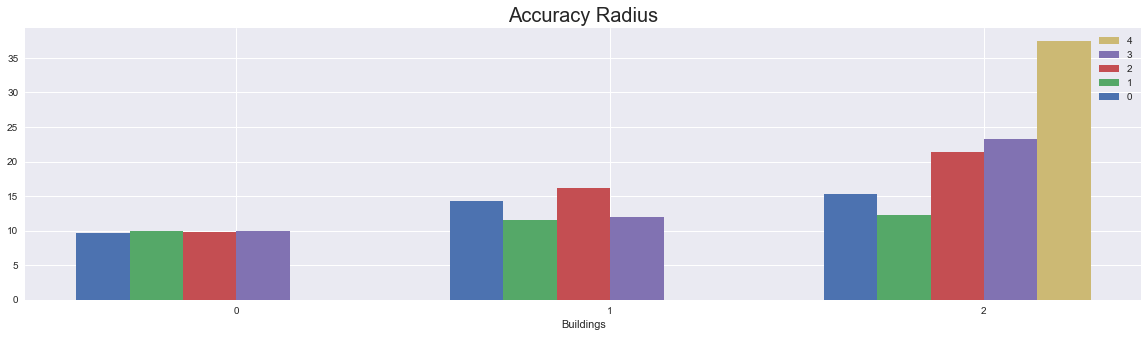

In [0]:
dist_error = test_sub.groupby(['BUILDINGID', 'FLOOR']).dist_error.mean().reset_index().pivot(index='BUILDINGID',columns='FLOOR').fillna(0)
plt.figure(figsize=(20,5))
bars = create_clustered_bar(dist_error.values,plt)
plt.legend((reversed([x[0] for x in bars])), (4,3,2,1,0),fancybox=True)
plt.title('Accuracy Radius',fontsize=20)
plt.xticks(dist_error.index)
plt.xlabel('Buildings')
plt.show()

Based on the breakdown of accuracy by building & floor, the top-most building in the scatter plot is most likely Building 2, with the highest concentration of inaccuracy from Level 4 records.

In [0]:
se_corr=np.corrcoef([item for sublist in signal_fb.values.tolist() for item in sublist], [item for sublist in dist_error.values.tolist() for item in sublist])[0,1]
print('Correlation coefficient between Accuracy Radius and Average Max Signal Strength: %.4f' % se_corr)

Correlation coefficient between Accuracy Radius and Average Max Signal Strength: -0.5121


There is a moderate negative relationship between Prediction Accuracy and Max Signal Strength (stronger relationship than from the Classification model) - 51.21% of the predicted accuracy radius by building x floor can be explained by how strong the max signal is.

### Step 3: Model improvements
Given the current accuracy radius of 13.15 metres, the current K-Nearest Neighbours model can be further improved by changing the K value.

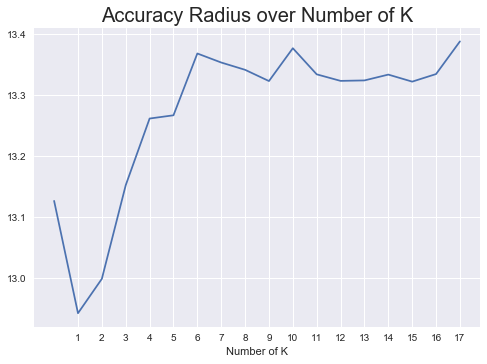

In [0]:
k_results = []

for k in np.arange(2, 20):
    reg_knn_test = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k), n_jobs=-1)
    reg_knn_test.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
    reg_preds_test = reg_knn_test.predict(test[[x for x in train.columns if 'WAP' in x]])
    temp_df = pd.concat([test_sub[['LATITUDE','LONGITUDE']], 
                         pd.DataFrame(columns=['pred_lat_tuned','pred_long_tuned'], data = reg_preds_test)],axis=1)
    temp_df['dist_error_tuned'] = temp_df.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long_tuned'], row['LATITUDE'], row['pred_lat_tuned']),axis=1)
    k_results.append(temp_df['dist_error_tuned'].mean())

plt.plot(k_results)
plt.title('Accuracy Radius over Number of K', fontsize=20)
plt.xlabel('Number of K')
plt.xticks(range(1,len(k_results)),label=np.arange(2, 20))
plt.show()

Given that there are 3 buildings, k = 3 is selected to tune the model and increase the accuracy.

In [0]:
reg_knn_tuned = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3), n_jobs=-1)
reg_knn_tuned.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
reg_preds_tuned = reg_knn_tuned.predict(test[[x for x in train.columns if 'WAP' in x]])

new_rsq = r2_score(test[['LATITUDE','LONGITUDE']].values, reg_preds_tuned)
print('R-squared score: %.4f' % new_rsq)
print('Uplift in R-squared score: %.2f%%' % ((new_rsq-rsq)/rsq*100))
print()
print('Mean Squared Error:')
ll_mse_tuned = dict(zip(['Latitude', 'Longitude'], mean_squared_error(test[['LATITUDE','LONGITUDE']].values, reg_preds_tuned, multioutput='raw_values')))
for k, v in ll_mse_tuned.items():
    print('\t%s: %.2f' % (k, v))
print('Uplift in Mean Squared Error:')
for k, v in ll_mse_tuned.items():
    uplift = (ll_mse[k]-v)/ll_mse[k]
    print('\t%s: %.2f%%' % (k, (uplift*100)))

R-squared score: 0.9779
Uplift in R-squared score: 0.27%

Mean Squared Error:
	Latitude: 194.12
	Longitude: 234.70
Uplift in Mean Squared Error:
	Latitude: 6.11%
	Longitude: 13.92%


In [0]:
test_sub = pd.concat([test_sub[['LATITUDE','LONGITUDE', 'BUILDINGID', 'FLOOR', 'pred_lat', 'pred_long']], 
                     pd.DataFrame(columns=['pred_lat_tuned','pred_long_tuned'], data = reg_preds_tuned)],axis=1)
test_sub['dist_error_tuned'] = test_sub.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long_tuned'], row['LATITUDE'], row['pred_lat_tuned']),axis=1)

In [0]:
tuned_ar = test_sub['dist_error_tuned'].mean()
print('On average, the current model is accurate up to %.2fm radius (%.2f%% improvement).' % (tuned_ar, ((org_ar-tuned_ar)/org_ar*100)))

On average, the current model is accurate up to 12.94m radius (1.59% improvement).


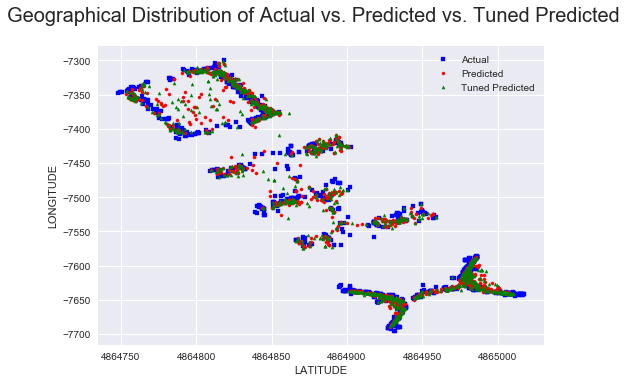

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.suptitle('Geographical Distribution of Actual vs. Predicted vs. Tuned Predicted',fontsize=20)
ax1.scatter(test_sub['LATITUDE'], test_sub['LONGITUDE'], s=10, c='b', marker="s", label='Actual')
ax1.scatter(test_sub['pred_lat'],test_sub['pred_long'], s=10, c='r', marker="o", label='Predicted')
ax1.scatter(test_sub['pred_lat_tuned'],test_sub['pred_long_tuned'], s=10, c='g', marker="^", label='Tuned Predicted')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.legend(loc='upper right')
plt.show()

A visual comparison shows that Building 2's inaccuracy is reduced, with less predicted values within the empty space in the middle of the building.

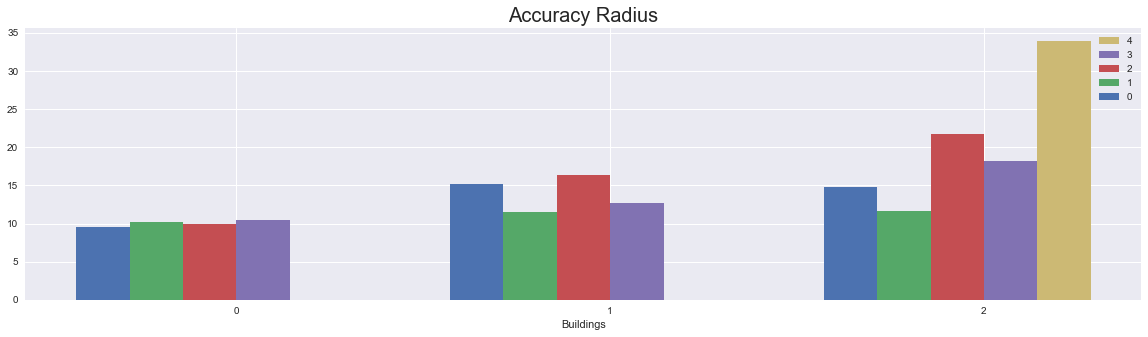

In [0]:
dist_error_tuned = test_sub.groupby(['BUILDINGID', 'FLOOR']).dist_error_tuned.mean().reset_index().pivot(index='BUILDINGID',columns='FLOOR').fillna(0)
plt.figure(figsize=(20,5))
bars = create_clustered_bar(dist_error_tuned.values,plt)
plt.legend((reversed([x[0] for x in bars])), (4,3,2,1,0),fancybox=True)
plt.title('Accuracy Radius',fontsize=20)
plt.xticks(dist_error_tuned.index)
plt.xlabel('Buildings')
plt.show()

In [0]:
org_mat = dist_error.as_matrix()
tuned_mat = dist_error_tuned.as_matrix()

fb_uplift = pd.DataFrame(index=dist_error.columns.droplevel(),
                         columns=dist_error.index,
                         data=((org_mat-tuned_mat)/org_mat).T).fillna(0)
for col in fb_uplift.columns:
    fb_uplift[col] = fb_uplift[col].apply(lambda x: "%.2f%%" % (x*100))

print('Uplift in Accuracy Radius by Building & Floor:')
fb_uplift.sort_index(ascending=False)

Uplift in Accuracy Radius by Building & Floor:


BUILDINGID,0,1,2
FLOOR,,,
4,0.00%,0.00%,9.38%
3,-4.36%,-5.45%,21.97%
2,-0.84%,-1.02%,-1.45%
1,-2.68%,0.07%,4.47%
0,1.69%,-5.84%,2.67%


* Floor 3 of Building 1 is most negatively affected by the change in K values in model tuning
* Building 1 is generally negatively impacted across all levels (except Floor 1)
* Building 2 most positive changes across all levels (except Level 2)
* Building 2 main improvement in Floor 3

## Overall Modelling Results
* Building: 100% accuracy
* Floor: 88.66% accuracy
* Position based on Latitude + Longitude: 12.96m radius

## Areas for Improvement
* Increase accuracy of predicted floor
* Reduce accuracy radius
* Add other dimensions into models e.g. examine effect of time of day / day of week on predictions